<a href="https://colab.research.google.com/github/Youki/cloud-ai-handson/blob/master/machine_learning/cloud_ai_building_blocks/sight_ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---
```
Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```
---

## Google Cloud API の認証情報を入力

Google Cloud API を REST インタフェースから利用するために、 [API Key](https://console.cloud.google.com/apis/credentials) を利用します。 Google Cloud Console から API Key をコピーしましょう。

In [0]:
import getpass
APIKEY = getpass.getpass()

··········


## Cloud Vision API を使ってみよう !

**Cloud Vision API** では、静止画を認識して画像の中に含まれる物を特定したり、文字を抽出したり （OCR) 、Web上から同一の画像を探す事ができます。このノートブックでは、以下 4 種類の認識を行います。
- **オブジェクト検知** - 画像中の物体の名称や位置を検出します
- **顔検出** - 画像中の顔検出や表情からの感情予測を行います
- **ロゴ検出** - 画像中に存在する有名ブランドのロゴを検出します
- **ランドマーク検知** - 有名な観光地の画像から、その地名と位置を特定します

### Cloud Vision API の準備

API Discovery Service を利用して **Cloud Vision API** を発見します。 Cloud Vision の REST API 仕様は [こちら](https://cloud.google.com/vision/docs/reference/rest/) に解説されています。

In [0]:
from googleapiclient.discovery import build

vision_service = build('vision', 'v1p3beta1', developerKey=APIKEY)

### オブジェクト検知
オブジェクト検知とは、画像中のどの領域にどんなオブジェクト（例えば車やリンゴといった一般的な”物”）があるかを特定します。

#### Colab 環境への画像アップロード

次のセルを実行して、ローカルに保存された objects.jpg をアップロードします。

In [0]:
from google.colab import files
uploaded = files.upload()

Saving objects.jpg to objects.jpg


再アップロードすると、ファイルは上書きではなく別ファイル名で保存されます。ファイルを消したい場合は以下のコマンドを実行します。

In [0]:
# !rm ./objects.jpg

#### Request メッセージの構築

API には画像データと、どんな検知をやりたいのかという情報を渡す必要があります。今回は REST API を使っているので、 HTTP Request の Payload に、 JSON 形式で画像データと検知のタイプを指定して渡します。画像データは GCS (Google Cloud Storage) のパスを指定する方法もありますが、今回は直接ファイルの中身を Payload に入れて送ります。直接 Payload に入れる場合は、ファイルの中身を Base64 エンコードする必要があります。

In [0]:
from base64 import b64encode

with open('objects.jpg', 'rb') as image_file:
  my_image = {
      'content': b64encode(image_file.read()).decode('utf-8')
  }

In [0]:
my_features = [
    {'type':'OBJECT_LOCALIZATION', 'model':'builtin/stable'}
]

In [0]:
my_body={
    'requests': [
        {'image': my_image, 'features': my_features}
    ]
}

#### Request メッセージの送信

In [0]:
response = vision_service.images().annotate(body=my_body).execute()

#### 検出結果の可視化

オブジェクト検知では、検出されたオブジェクトの名称、矩形位置情報（画像中の座標）とその確度が返ってきます。ここではその情報を使って、画像中の何が検出されたのかを描画して確かめてみましょう。次のセルを実行すると検知したオブジェクトをハイライトする便利関数 ```highlight_objects``` が定義されます。

In [0]:
#@title 検出したオブジェクトをハイライトする関数 highlight_objects を定義

from PIL import Image, ImageDraw

def highlight_objects(image_file, objects):
  image = Image.open(image_file)
  draw = ImageDraw.Draw(image, "RGBA")
  
  width = image.getbbox()[-2]
  height = image.getbbox()[-1]
  
  for object in objects:
    n_vertex_lt = tuple(object['boundingPoly']['normalizedVertices'][0].values())
    n_vertex_rb = tuple(object['boundingPoly']['normalizedVertices'][2].values())
    
    vertex_lt = (int(n_vertex_lt[0] * width), int(n_vertex_lt[1] * height))
    vertex_rb = (int(n_vertex_rb[0] * width), int(n_vertex_rb[1] * height))
    
    # bounding box
    draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
    
    # probability
    object['name']
    draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
              text=object['name'] + ':' + str(format(object['score'], '.3f')),
              fill='red')    
  display(image)

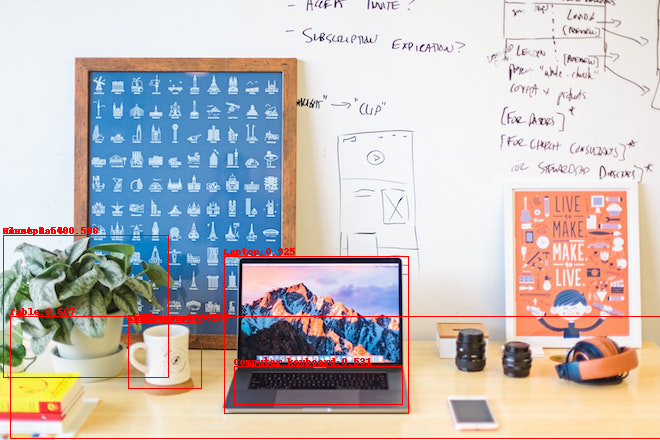

In [0]:
highlight_objects('objects.jpg', response['responses'][0]['localizedObjectAnnotations'])

#### Response メッセージの中身を確認

Responseメッセージは、JSONの形式で返ってきます。どんなデータが内包されているのか、確認してみましょう。

In [0]:
response['responses'][0]['localizedObjectAnnotations']

[{'boundingPoly': {'normalizedVertices': [{'x': 0.34023532, 'y': 0.5828236},
    {'x': 0.61905885, 'y': 0.5828236},
    {'x': 0.61905885, 'y': 0.9397647},
    {'x': 0.34023532, 'y': 0.9397647}]},
  'mid': '/m/01c648',
  'name': 'Laptop',
  'score': 0.9247296},
 {'boundingPoly': {'normalizedVertices': [{'x': 0.19407739, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.8820837},
    {'x': 0.19407739, 'y': 0.8820837}]},
  'mid': '/m/03_wxk',
  'name': 'Kitchenware',
  'score': 0.73515165},
 {'boundingPoly': {'normalizedVertices': [{'x': 0.19407739, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.8820837},
    {'x': 0.19407739, 'y': 0.8820837}]},
  'mid': '/m/04brg2',
  'name': 'Tableware',
  'score': 0.63077563},
 {'boundingPoly': {'normalizedVertices': [{'x': 0.19407739, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.7320837},
    {'x': 0.30595976, 'y': 0.8820837},
    {'x': 0.19407739, 'y': 0.8820837}]},
  'mid': '/

### 顔検出
顔検出では、画像中にある顔の検出、表情からの感情予測を行います。


#### Colab 環境に画像を用意する

下記セルを実行すると写真撮影用の関数 `take_photo` が定義される

In [0]:
#@title このセルを実行すると、写真撮影用の関数 "take_photo" が定義される

from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

VIDEO_HTML = """
<video autoplay
 width=600 height=450></video>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8):
  display(HTML(VIDEO_HTML % quality))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

In [0]:
take_photo(filename='my_face.jpg')

22645

#### Request メッセージの構築
ここでは、上で撮影した画像を使います。

In [0]:
from base64 import b64encode

with open('my_face.jpg', 'rb') as image_file:
  my_image = {
      'content': b64encode(image_file.read()).decode('utf-8')
  }

In [0]:
my_features = [
    {'type':'FACE_DETECTION', 'model':'builtin/stable'},
]

In [0]:
my_body={
    'requests': [
        {'image': my_image, 'features': my_features}
    ]
}

#### Request メッセージの送信

In [0]:
response = vision_service.images().annotate(body=my_body).execute()

#### 検出結果の可視化
ここでも、検出した顔の矩形情報が得られるのでそれを描画してみましょう。次のセルを実行すると検知したオブジェクトをハイライトする便利関数 `highlight_faces` が定義されます。

In [0]:
#@title 検出した顔をハイライトする関数 highlight_faces を定義

from PIL import Image, ImageDraw

def highlight_faces(image_file, faces):
  image = Image.open(image_file)
  draw = ImageDraw.Draw(image, "RGBA")
  
  for face in faces:
    vertex_lt = tuple(face['boundingPoly']['vertices'][0].values())
    vertex_rb = tuple(face['boundingPoly']['vertices'][2].values())
    
    # bounding box
    draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
    
    # probability
    draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
              text=str(format(face['detectionConfidence'], '.3f')),
              fill='red')    
  display(image)

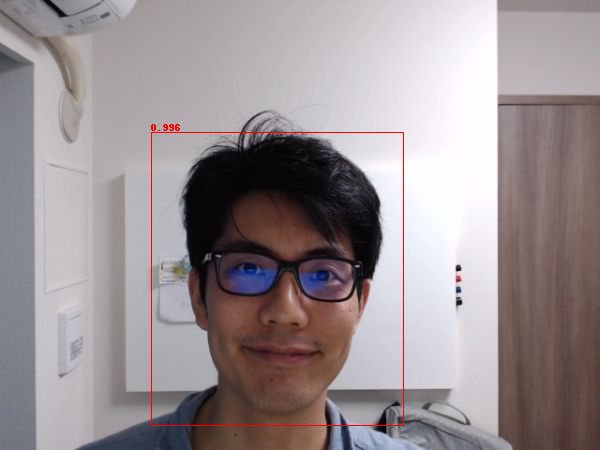

In [0]:
highlight_faces('my_face.jpg', response['responses'][0]['faceAnnotations'])

表情から読み取れる感情の予測結果表示する。

In [0]:
face_response = response['responses'][0]['faceAnnotations']

keys = ['angerLikelihood',  'joyLikelihood', 'sorrowLikelihood',
        'surpriseLikelihood', 'headwearLikelihood']

for key in keys:
  print(key, "==>", face_response[0][key])

angerLikelihood ==> VERY_UNLIKELY
joyLikelihood ==> POSSIBLE
sorrowLikelihood ==> VERY_UNLIKELY
surpriseLikelihood ==> VERY_UNLIKELY
headwearLikelihood ==> VERY_UNLIKELY


### ロゴ検知

ロゴ検知では、画像中にある（有名ブランドなどの）ロゴを検出します。

#### Colab 環境への画像アップロード

次のセルを実行して、ローカルに保存された googleplex.jpg をアップロードします。

In [0]:
from google.colab import files
uploaded = files.upload()

Saving googleplex.jpg to googleplex.jpg


再アップロードすると、ファイルは上書きではなく別ファイル名で保存されます。ファイルを消したい場合は以下のコマンドを実行します。

In [0]:
# !rm ./googleplex.jpg

#### Request メッセージを構築してみよう
ここでは、 **googleplex.jpg** の画像を使います。Requestのしかたは先ほどと同じで、画像データと `type`が異なるだけです。

In [0]:
from base64 import b64encode

with open('googleplex.jpg', 'rb') as image_file:
  my_image = {
      'content': b64encode(image_file.read()).decode('utf-8')
  }

In [0]:
my_features = [
    {'type':'LOGO_DETECTION', 'model':'builtin/stable'}
]

In [0]:
my_body={
    'requests': [
        {'image': my_image, 'features': my_features}
    ]
}

#### Request メッセージの送信

In [0]:
response = vision_service.images().annotate(body=my_body).execute()

#### 検出結果を可視化しよう
ここでも、検出したロゴの矩形情報が得られるのでそれを描画してみましょう。次のセルを実行すると検知したオブジェクトをハイライトする便利関数 `highlight_logos` が定義されます。

In [0]:
#@title 検出したオブジェクトをハイライトする関数 highlight_logos を定義

from PIL import Image, ImageDraw

def highlight_logos(image_file, objects):
  image = Image.open(image_file)
  draw = ImageDraw.Draw(image, "RGBA")
  
  for obj in objects:
    vertex_lt = tuple(obj['boundingPoly']['vertices'][0].values())
    vertex_rb = tuple(obj['boundingPoly']['vertices'][2].values())
    
    # bounding box
    draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
    
    # probability
    obj['description']
    draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
              text=obj['description'] + ':' + str(format(obj['score'], '.3f')),
              fill='red')    
  display(image)

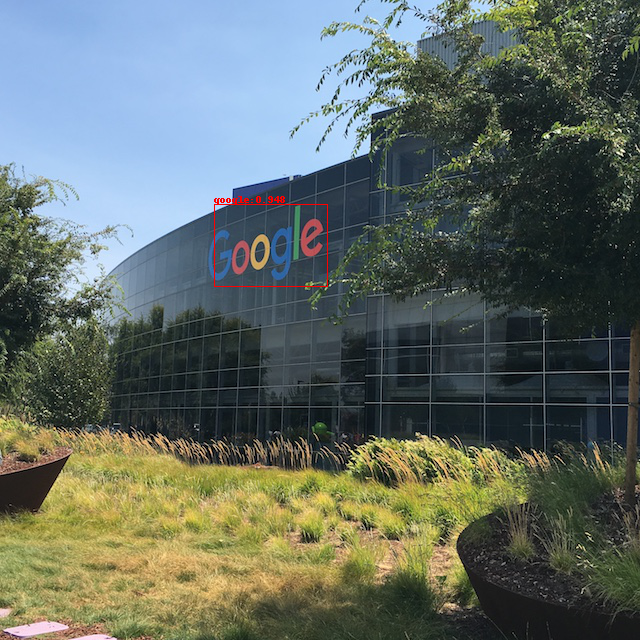

In [0]:
highlight_logos('googleplex.jpg', response['responses'][0]['logoAnnotations'])

#### Response メッセージの中身を確認

オブジェクト検知とほぼ同じ形式です。`mid`とは、[Google Knowledge Graph](https://en.wikipedia.org/wiki/Knowledge_Graph)のIDです。

In [0]:
response['responses'][0]['logoAnnotations']

[{'boundingPoly': {'vertices': [{'x': 214, 'y': 204},
    {'x': 327, 'y': 204},
    {'x': 327, 'y': 286},
    {'x': 214, 'y': 286}]},
  'description': 'google',
  'mid': '/m/045c7b',
  'score': 0.9477}]

### ランドマーク検知
ランドマーク検知では、有名な観光地や場所を特定することができます。

#### Colab 環境への画像アップロード

次のセルを実行して、ローカルに保存された osaka.jpg をアップロードします。

In [0]:
from google.colab import files
uploaded = files.upload()

Saving osaka.jpg to osaka.jpg


再アップロードすると、ファイルは上書きではなく別ファイル名で保存されます。ファイルを消したい場合は以下のコマンドを実行します。

In [0]:
!rm ./osaka.jpg

#### Request メッセージの構築

In [0]:
from base64 import b64encode

with open('osaka.jpg', 'rb') as image_file:
  my_image = {
      'content': b64encode(image_file.read()).decode('utf-8')
  }

In [0]:
my_features = [
    {'type':'LANDMARK_DETECTION', 'model':'builtin/stable'}
]

In [0]:
my_body={
    'requests': [
        {'image': my_image, 'features': my_features}
    ]
}

#### Request メッセージの送信

In [0]:
response = vision_service.images().annotate(body=my_body).execute()

#### 検出結果の可視化
ここでも、検出したランドマークの矩形情報が得られるのでそれを描画してみましょう。次のセルを実行すると検知したオブジェクトをハイライトする便利関数 `highlight_landmarks` が定義されます。

In [0]:
#@title 検出したオブジェクトをハイライトする関数 highlight_landmarks を定義

from PIL import Image, ImageDraw

def highlight_landmarks(image_file, objects):
  image = Image.open(image_file)
  draw = ImageDraw.Draw(image, "RGBA")
  
  for obj in objects:
    vertex_lt = tuple(obj['boundingPoly']['vertices'][0].values())
    vertex_rb = tuple(obj['boundingPoly']['vertices'][2].values())
    
    # bounding box
    draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
    
    # probability
    obj['description']
    draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
              text=obj['description'] + ':' + str(format(obj['score'], '.3f')),
              fill='red')    
  display(image)

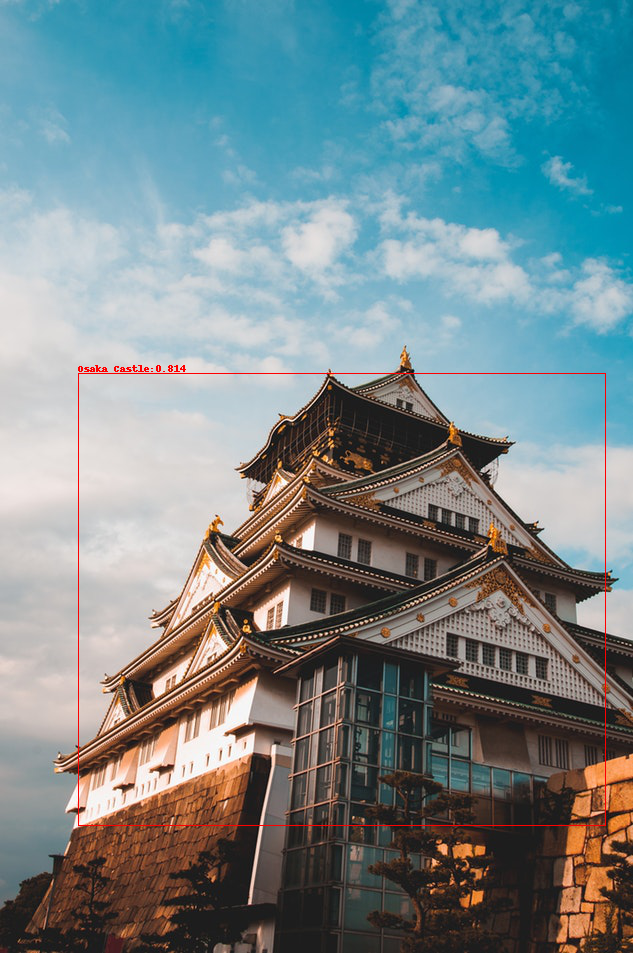

In [0]:
highlight_landmarks('osaka.jpg', response['responses'][0]['landmarkAnnotations'])

#### プラス One!  
Maps APIを使って検知したランドマークの位置を地図に表示しよう。地図の表示は [Google Maps Static API](https://console.cloud.google.com/apis/library/static-maps-backend.googleapis.com) を使っているので、別途 API を有効にする必要があります。

In [0]:
from IPython.core.display import HTML

latlng = response['responses'][0]['landmarkAnnotations'][0]['locations'][0]['latLng']

html = """
<img src="https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom=14&size=680x300&key={}">
""".format(latlng['latitude'], latlng['longitude'], APIKEY)
display(HTML(html))

#### Response メッセージの中身を確認

In [0]:
response['responses'][0]['landmarkAnnotations']

[{'boundingPoly': {'vertices': [{'x': 65, 'y': 51},
    {'x': 111, 'y': 51},
    {'x': 111, 'y': 105},
    {'x': 65, 'y': 105}]},
  'description': 'Osaka Castle',
  'locations': [{'latLng': {'latitude': 34.686777, 'longitude': 135.525799}}],
  'mid': '/m/024b_g',
  'score': 0.20166214}]

#### Tips

複数の検知を一度にリクエストすることもできます。

In [0]:
# Requestのmy_features部分を以下のように複数指定する
my_features = [
    {'type':'OBJECT_LOCALIZATION', 'model':'builtin/stable'},
    {'type':'LOGO_DETECTION', 'model':'builtin/stable'},
    {'type':'LANDMARK_DETECTION', 'model':'builtin/stable'}
]